# Artificial Neural Networks and Deep Learning

---

## Homework 1

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 1` in your Google Drive.
2. Upload the `training_set.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 1 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.zip` file to Codabench.


## 🌐 Connect Colab to Google Drive

In [1]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/Boracchi
# directory of my folder in google drive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Boracchi


## ⚙️ Import Libraries

In [2]:
# libraries settings: here I'll add all the necessary libraries during
# the code development

seed = 85 # random variable to make the code reproducible

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import numpy as np
import hashlib
import logging
import random

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from PIL import Image
import matplotlib.gridspec as gridspec

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


## ⏳ Load the Data

In [3]:
data = np.load('training_set.npz') # load the blood cells dataset into a variable called 'data'
print(data.files)
# as we can see in the previus output, the dataset is composed by two arrays: images and labels

['images', 'labels']


In [4]:
# Define a mapping of labels to their corresponding digit names
classes = {0:'Basophil', 1:'Eosinophil', 2:'Erythroblast', 3:'Immature granulocytes', 4:'Lymphocyte', 5:'Monocyte', 6:'Neutrophil', 7:'Platelet'} # 8 classes
# Save unique labels
unique_labels = list(classes.values())

In [5]:
# splitting between images and labels
X = data['images']
y = data['labels']
print(X.shape)
print(y.shape)
# we have 13759 observations that are images of height and weight equal to 96 and 3 channels (RGB images)

(13759, 96, 96, 3)
(13759, 1)


In [ ]:
# show a sample of images from the training set

num_img = 50 # 50 random images
random_indices = random.sample(range(len(X)), num_img)

fig, axes = plt.subplots(10, 5, figsize=(20, 20))

# iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i // 5, i % 5]
    ax.imshow(np.squeeze(X[idx]), vmin=0., vmax=1.)
    ax.set_title(f'{classes[y[idx][0]]}')
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Searching for duplicates

In [6]:
# Dictionary to store image hashes and their indices
hash_dict = {}
duplicates = []

for idx, img in enumerate(X):
    # Convert the image to bytes to create a hash
    img_bytes = img.tobytes()
    img_hash = hashlib.md5(img_bytes).hexdigest()

    # Check if the hash exists in hash_dict
    if img_hash in hash_dict:
        # print(f"Duplicate found at index {idx}, duplicate of index {hash_dict[img_hash]}")
        duplicates.append(idx)  # Mark this index as a duplicate
    else:
        hash_dict[img_hash] = idx  # Store unique hash with its index

# Remove duplicates from X and y
X_unique = np.delete(X, duplicates, axis=0)
y_unique = np.delete(y, duplicates, axis=0)

# Save the deduplicated dataset if desired
np.savez('deduplicated_training_set.npz', images=X_unique, labels=y_unique)

print(f"Removed {len(duplicates)} duplicates. New dataset has {len(X_unique)} images.")

Removed 1806 duplicates. New dataset has 11953 images.


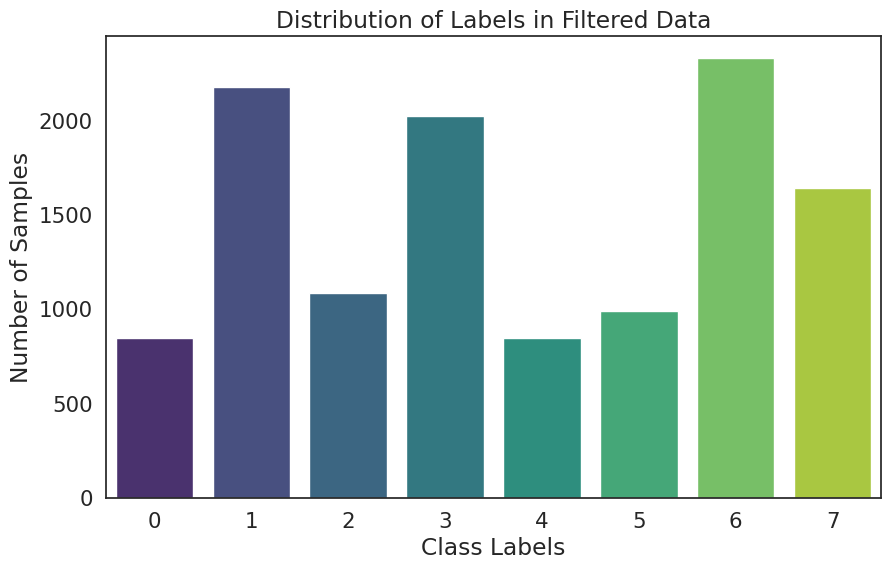

In [7]:
# Count the number of occurrences for each label in y
unique_labels, label_counts = np.unique(y_unique, return_counts=True)

# Plotting the label distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=unique_labels, y=label_counts, palette='viridis')

plt.title('Distribution of Labels in Filtered Data')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.xticks(unique_labels)
plt.show()

In [8]:
# Normalize data to the range [0, 1] dividendo per 255 così lavora più velocemente e meglio
X_unique = (X_unique / 255).astype('float32')

In [9]:
# keeping 80% for the training set and 20% for the validation
X_train, X_val, y_train, y_val = train_test_split(X_unique, y_unique, test_size=0.2, random_state=42)

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)

Train: (9562, 96, 96, 3) (9562, 1)
Validation: (2391, 96, 96, 3) (2391, 1)


## Bilanciamento delle classi

In [10]:
# Flatten y_train to a 1D array before passing it to compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train.ravel())
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print(class_weight_dict)

{0: 1.7919790104947526, 1: 0.6806662870159453, 2: 1.3898255813953488, 3: 0.7433146766169154, 4: 1.7525659824046922, 5: 1.505352644836272, 6: 0.6290789473684211, 7: 0.922972972972973}


In [11]:
# Convert labels to categorical format using one-hot encoding
y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)

In [12]:
# Compare categorical label and "default" label representation
print('Categorical label:', y_train[0])
print('"Default" label:', np.argmax(y_train[0]))

Categorical label: [0. 0. 0. 1. 0. 0. 0. 0.]
"Default" label: 3


## Network Parameters

In [13]:
input_shape = (96,96,3) # input shape basta che sia multiplo di 32 per la SENet quindi lasciamo 96,96,3
output_shape = y_train.shape[1] # output shape of the model: 8 classi
print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

# it makes sense because the input shape is the dimension of the image and 3 channels
# and the output is 8 as the number of the possible classes

Input Shape: (96, 96, 3)
Output Shape: 8


In [39]:
epochs = 300 # epochs
batch_size = 64 # batch
learning_rate = 0.001 # step size for updating the model's weights

# Initialise configuration
stack = 1 # solo un layer
filters = 32
kernel_size = 3

In [40]:
# early stopping
patience = 100

early_stopping = tfk.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    mode = 'max',
    patience = patience,
    restore_best_weights = True
)

callbacks = [early_stopping]

## 🛠️ Train and Save the Model

In [51]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Conv2D, MaxPooling2D, Dropout

# model building
def build_model(input_shape,
                output_shape,
                learning_rate=0.001,
                seed=seed
                ):

    tf.random.set_seed(seed)

    # Input layer 96x96x3
    inputs = tf.keras.Input(shape=input_shape, name='Input')

    # Augmentation
    augmentation_choosen = tf.keras.Sequential([
        layers.RandomZoom(0.2),  # Zoom leggero, circa 20%
        layers.RandomFlip('horizontal_and_vertical'),
        layers.RandomTranslation(0.2, 0.2),  # Traslazione 20%
        layers.RandomRotation(0.2),  # Rotazione fino a ±20°
        layers.RandomBrightness(0.2, value_range=(0, 1)),  # Luminosità microscopi
        layers.RandomContrast(0.2),  # Contrasto
    ], name='preprocessing')

    x = augmentation_choosen(inputs)

    x = tfkl.Conv2D(filters=filters, kernel_size=1, activation='linear', padding='same', name='conv0')(x)

    # ResNet Block 32
    s1 = tfkl.Conv2D(filters=filters, kernel_size=3, padding='same', activation='relu', name='conv1')(x)
    s2 = tfkl.Conv2D(filters=filters, kernel_size=3, padding='same', activation='relu', name='conv2')(s1)

    # Shortcut connection con convoluzione 1x1 per allineare le dimensioni (se necessario)
    s3 = tfkl.Conv2D(filters=filters, kernel_size=1, padding='same', activation='linear', name='conv_add1x1')(x)
    s4 = tfkl.Add(name='add1')([s3, s2])
    s5 = tfkl.ReLU(name='relu1')(s4)
    s6 = tfkl.MaxPooling2D(pool_size=(2, 2), name='pooling1')(s5)

    # ResNet Block 64
    s7 = tfkl.Conv2D(64, kernel_size=3, padding='same', activation='relu', name='conv3')(s6)
    s8 = tfkl.Conv2D(64, kernel_size=3, padding='same', activation='relu', name='conv4')(s7)

    # Shortcut connection con convoluzione 1x1 per allineare le dimensioni (se necessario)
    s9 = tfkl.Conv2D(64, kernel_size=1, padding='same', activation='linear', name='conv_add2x1')(s6)
    s10 = tfkl.Add(name='add2')([s9, s8])  # Addizione del blocco con il tensore di ingresso
    s11 = tfkl.ReLU(name='relu2')(s10)
    s12 = tfkl.MaxPooling2D(pool_size=(2, 2), name='pooling2')(s11)

    # ResNet Block 128
    s13 = tfkl.Conv2D(128, kernel_size=3, padding='same', activation='relu', name='conv5')(s12)
    s14 = tfkl.Conv2D(128, kernel_size=3, padding='same', activation='relu', name='conv6')(s13)

    # Shortcut connection con convoluzione 1x1 per allineare le dimensioni (se necessario)
    s15 = tfkl.Conv2D(128, kernel_size=1, padding='same', activation='linear', name='conv_add3x1')(s12)
    s16 = tfkl.Add(name='add3')([s15, s14])  # Addizione del blocco con il tensore di ingresso
    s17 = tfkl.ReLU(name='relu3')(s16)
    s18 = tfkl.MaxPooling2D(pool_size=(2, 2), name='pooling3')(s17)

    # Flatten and dense layers
    flat = tfkl.Flatten(name='flatten')(s18)
    dense1 = tfkl.Dense(256, activation='relu', name='dense1')(flat)
    drop1 = tfkl.Dropout(0.4, name='dropout1')(dense1)
    dense2 = tfkl.Dense(128, activation='relu', name='dense2')(drop1)
    drop2 = tfkl.Dropout(0.4, name='dropout2')(dense2)

    # Output layer dimension = 8 (for example)
    sout = tfkl.Dense(units=output_shape, name='dense')(drop2)  # Dense layer for classification
    outputs = tfkl.Activation('softmax', name='softmax')(sout)

    # Connect input and output through the Model class
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='CNN')

    # Compile the model
    loss = tfk.losses.CategoricalCrossentropy()
    optimizer = tfk.optimizers.Adam(learning_rate)
    metrics = ['accuracy']
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    return model

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)     │ (None, 96, 96, 3)    │            0 │ -                   │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ preprocessing          │ (None, 96, 96, 3)    │            0 │ Input[0][0]         │    -    │
│ (Sequential)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ random_zoom_12    │ (None, 96, 96, 3)    │            0 │ -                   │    -    │
│ (RandomZoom)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ random_flip_12    │ (None, 96, 96, 3)    │            0 │ -                   │    -    │
│ (RandomFlip)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 96, 96, 3)    │            0 │ -                   │    -    │
│ random_translation_12  │                      │              │                     │         │
│ (RandomTranslation)    │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 96, 96, 3)    │            0 │ -                   │    -    │
│ random_rotation_12     │                      │              │                     │         │
│ (RandomRotation)       │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 96, 96, 3)    │            0 │ -                   │    -    │
│ random_brightness_12   │                      │              │                     │         │
│ (RandomBrightness)     │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 96, 96, 3)    │            0 │ -                   │    -    │
│ random_contrast_12     │                      │              │                     │         │
│ (RandomContrast)       │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv0 (Conv2D)         │ (None, 96, 96, 128)  │          512 │ preprocessing[0][0] │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv1 (Conv2D)         │ (None, 96, 96, 128)  │      147,584 │ conv0[0][0]         │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv_add1x1 (Conv2D)   │ (None, 96, 96, 128)  │       16,512 │ conv0[0][0]         │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2 (Conv2D)         │ (None, 96, 96, 128)  │      147,584 │ conv1[0][0]         │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ add1 (Add)             │ (None, 96, 96, 128)  │            0 │ conv_add1x1[0][0],  │    -    │
│                        │                      │              │ conv2[0][0]         │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ relu1 (ReLU)         

 Total params: 5,413,704 (20.65 MB)

 Trainable params: 5,413,704 (20.65 MB)

 Non-trainable params: 0 (0.00 B)

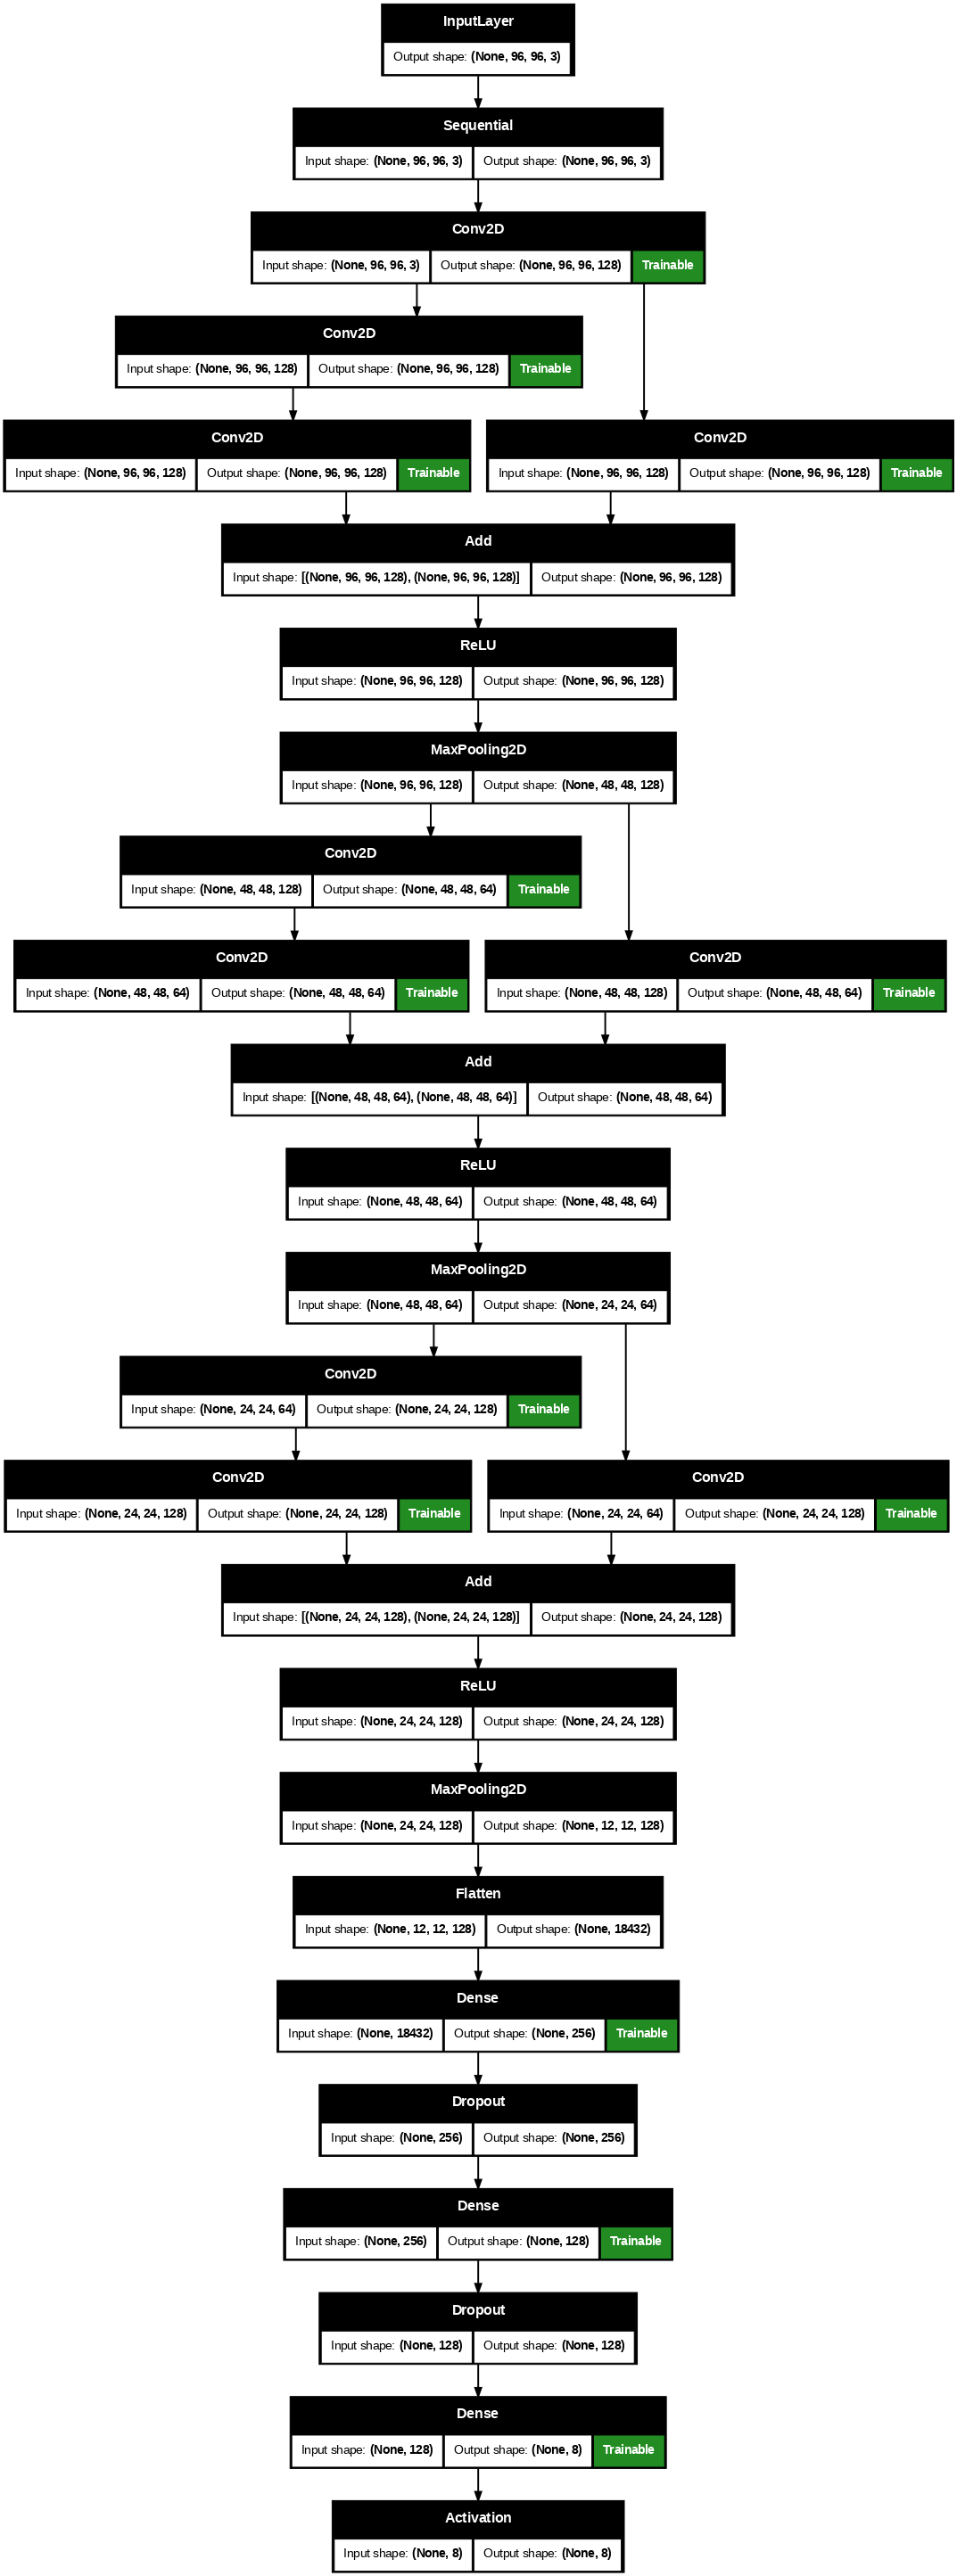

In [52]:
# Build the model with specified input and output shapes
model = build_model(
        input_shape=input_shape,
        output_shape=output_shape,
        learning_rate=learning_rate,
        seed=seed
)

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [ ]:
# Train the model
history = model.fit(
    x=X_train * 255,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    class_weight=class_weight_dict,
    validation_data=(X_val * 255, y_val),
    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)] # restore serve per il best model
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
model.save('weights.keras')

# Free memory by deleting the model instance
del model

Epoch 1/300
150/150 ━━━━━━━━━━━━━━━━━━━━ 50s 278ms/step - accuracy: 0.1103 - loss: 2.1299 - val_accuracy: 0.1506 - val_loss: 8.9333
Epoch 2/300
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 271ms/step - accuracy: 0.1302 - loss: 2.0789 - val_accuracy: 0.1610 - val_loss: 7.6544
Epoch 3/300
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 273ms/step - accuracy: 0.1194 - loss: 2.0791 - val_accuracy: 0.1665 - val_loss: 7.0038
Epoch 4/300
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 275ms/step - accuracy: 0.1334 - loss: 2.0791 - val_accuracy: 0.1514 - val_loss: 6.9570
Epoch 5/300
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 273ms/step - accuracy: 0.1355 - loss: 2.0791 - val_accuracy: 0.1782 - val_loss: 6.9249
Epoch 6/300
150/150 ━━━━━━━━━━━━━━━━━━━━ 80s 260ms/step - accuracy: 0.1474 - loss: 2.0789 - val_accuracy: 0.0916 - val_loss: 6.7497
Epoch 7/300
150/150 ━━━━━━━━━━━━━━━━━━━━ 39s 261ms/step - accuracy: 0.1219 - loss: 2.0788 - val_accuracy: 0.0765 - val_loss: 7.2864
Epoch 8/300
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 262ms/step - accuracy: 0.1167 -

In [ ]:
# 1. Diverse dimensioni di filtri per diverse scale
# 1 blocco di Resnet con filters a 32: 17% circa loss alta
# 1 blocco di Resnet con filters a 64: 21.25% loss alta si stabilizza a 187.9819
# 1 blocco di Resnet con filters a 128: 23.8% loss alta si stabilizza a 214.7687 migliora l'accuratezza ma peggiora la loss
# questi 3 in serie: la loss scende di molto

# 2. implementasione con diversi kernel - ricorda molto la inception

# 3. provo la inception

# 4. unisco resnet e inception: resnet come buon feature extractor e inception come buon learning multi scala

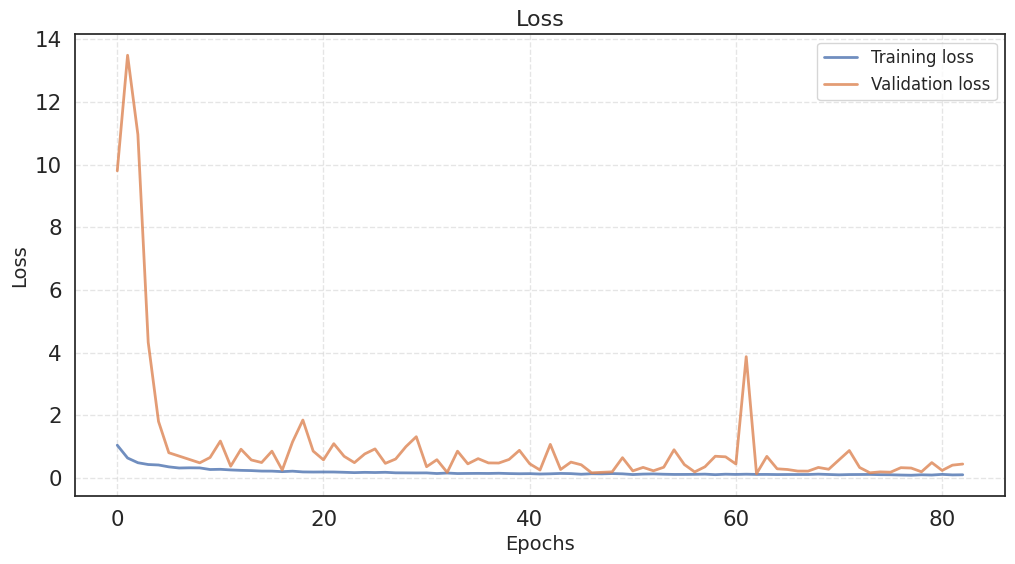

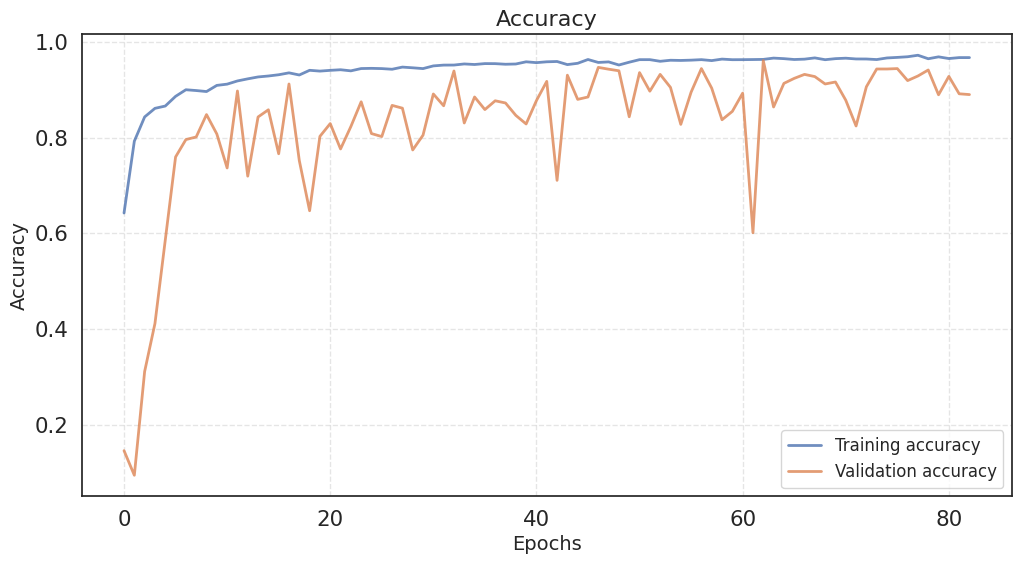

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history['loss'], label='Training loss', alpha=.8, linewidth=2)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8, linewidth=2)
plt.title('Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.5)

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, linewidth=2)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8, linewidth=2)
plt.title('Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()

In [ ]:
# Con tre strati ho molti più picchi

In [ ]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Overwriting model.py


In [ ]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py weights.keras

from google.colab import files
files.download(filename)

  adding: model.py (deflated 56%)
  adding: weights.keras (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>